# Predicting Wildfire Size from Historic Information & Drought Records
## Matt Timmons-Brown, Scott Kim, Jack Swift

Wildfires are unplanned and uncontrolled fires in areas of combustible vegtation such as forests. They happen most frequently during droughts and can be triggered by lightning, human activity, arson etc. In the United States, wildfires are responsible for decimating as much as 10 million acres per year [1]. Due to global warming, these figures are increasing.

It is therefore critical that Weather and Fire services can accurately predict and understand the gravity of a new wildfire as facts emerge about it, such as its location or current drought conditions. By then predicting the final size of a potential fire, emergency workers can prioritize the most seriously damaging cases. 

Specifically: **Our project is a fire size classification problem - given parameters of a fire, we have designed models that will predict the severity class of the fire. That way, firefighters can address their attention to the fires that have the potential to spread to the largest acreage.**

Result: **We develop a series of classical and neural network-based models that are capable of identifying fire size class with 65% accuracy. We then develop further models that classify with almost 80% accuracy whether a fire is serious or not. The latter models we believe are directly useful for firefighters in America.**

[1] https://en.wikipedia.org/wiki/Wildfires_in_the_United_States

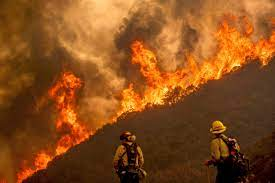

To solve this, in our Big Data project we have sourced 2 large datasets to combine and train our models on. To our knowledge, **these have never been combined or used in this way**:

* 1.88 Million US Wildfires - 24 years of geo-referenced wildfire records: https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires
* World Soil Database US Drought Monitor - 20 years of ground readings, wind speed and temperature records: https://www.kaggle.com/datasets/cdminix/us-drought-meteorological-data

In the notebook below we load this data, preprocess it, perform exploratory analysis and create models

In [ ]:
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
!pip install adjustText
from adjustText import adjust_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Pre-processing

Downloading the datasets from Kaggle. These are very large, and we had to ensure a sensible order as to not reach the default Colab RAM limits. Wildfire data is 800MB, soil data is 2.75GB.

We did this by reducing the size of intermediate dataframes during the loading and merging process with techniques that we learned from the first part of the Big Data course.

In [ ]:
%%capture
!apt update
!pip install kaggle

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!!kaggle datasets download -d rtatman/188-million-us-wildfires
!!kaggle datasets download -d cdminix/us-drought-meteorological-data

['Downloading us-drought-meteorological-data.zip to /content',
 '',
 '  0% 0.00/901M [00:00<?, ?B/s]',
 '  1% 5.00M/901M [00:00<00:21, 44.7MB/s]',
 '  3% 25.0M/901M [00:00<00:08, 114MB/s] ',
 '  4% 39.0M/901M [00:00<00:07, 123MB/s]',
 '  6% 51.0M/901M [00:00<00:12, 69.7MB/s]',
 '  7% 65.0M/901M [00:00<00:11, 78.2MB/s]',
 '  9% 81.0M/901M [00:00<00:08, 98.0MB/s]',
 ' 11% 101M/901M [00:01<00:06, 125MB/s]  ',
 ' 13% 121M/901M [00:01<00:08, 92.9MB/s]',
 ' 16% 144M/901M [00:01<00:06, 121MB/s] ',
 ' 18% 160M/901M [00:01<00:06, 126MB/s]',
 ' 19% 175M/901M [00:01<00:06, 110MB/s]',
 ' 21% 193M/901M [00:01<00:05, 126MB/s]',
 ' 23% 209M/901M [00:02<00:05, 126MB/s]',
 ' 25% 223M/901M [00:02<00:05, 131MB/s]',
 ' 26% 237M/901M [00:02<00:05, 120MB/s]',
 ' 28% 255M/901M [00:02<00:04, 136MB/s]',
 ' 30% 269M/901M [00:02<00:04, 135MB/s]',
 ' 32% 284M/901M [00:02<00:04, 139MB/s]',
 ' 33% 298M/901M [00:02<00:05, 109MB/s]',
 ' 35% 318M/901M [00:02<00:04, 131MB/s]',
 ' 37% 337M/901M [00:02<00:04, 142MB/s]',


In [ ]:
!unzip /content/188-million-us-wildfires.zip

Archive:  /content/188-million-us-wildfires.zip
  inflating: FPA_FOD_20170508.sqlite  


In [ ]:
!unzip /content/us-drought-meteorological-data.zip

Archive:  /content/us-drought-meteorological-data.zip
  inflating: soil_data.csv           
  inflating: test_timeseries/test_timeseries.csv  
  inflating: train_timeseries/train_timeseries.csv  
  inflating: validation_timeseries/validation_timeseries.csv  


Fire records start in 1992, whereas the soil readings and drought identifiers begin in 2000. As we are performing an inner join on these datasets, we would drop all of the fire records that don't overlap, so we may as well save loading them.

Below we use an SQL query to select all of the columns that we will use, and where the fire year is greater than 1999.

In [ ]:
con = sqlite3.connect("/content/FPA_FOD_20170508.sqlite")
fires_df = pd.read_sql_query('''SELECT FIPS_CODE, STATE, FIRE_SIZE, FIRE_SIZE_CLASS, FIRE_YEAR, STAT_CAUSE_CODE, STAT_CAUSE_DESCR, DISCOVERY_TIME, DISCOVERY_DOY, CONT_TIME, CONT_DOY
                                from Fires
                                WHERE FIRE_YEAR > 1999
                            ''', con)

Now we want to preprocess and clean the fire records before merging. To do this we define a helper function to convert the day of year information to a datetime object.

We also define a dictionary to convert the state name to a FIPS code. FIPS stands for the Federal Infromation Processing System [2] and these are numeric codes for different states and counties within the United States. We use these codes to join on a FIPS column within the soil records.

[2] https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt

In [ ]:
def day_of_year_to_datetime(day_of_year, year):
    return dt.datetime(year, 1, 1) + dt.timedelta(days=day_of_year - 1, )

st_to_fips = {
    "AL": "1", "AK": "2", "AZ": "4", "AR": "5", "CA": "6",
    "CO": "8", "CT": "9", "DE": "10", "DC": "11", "FL": "12",
    "GA": "13", "HI": "15", "ID": "16", "IL": "17", "IN": "18", 
    "IA": "19", "KS": "20", "KY": "21", "LA": "22", "ME": "23", 
    "MD": "24", "MA": "25", "MI": "26", "MN": "27", "MS": "28", 
    "MO": "29", "MT": "30", "NE": "31", "NV": "32", "NH": "33", 
    "NJ": "34", "NM": "35", "NY": "36", "NC": "37", "ND": "38", 
    "OH": "39", "OK": "40", "OR": "41", "PA": "42", "PR": "43", 
    "RI": "44", "SC": "45", "SD": "46", "TN": "47", "TX": "48", 
    "UT": "49", "VT": "50", "VA": "51", "WA": "53", "WV": "54", 
    "WI": "55", "WY": "56"
}

Here we preprocess the fire records. In total we:
* Create a new column for the FIPS state using the previously defined dictionary
* Drop any rows where the FIPS information, or the CONT_DOY (the day of the year a fire was contained) are NaN
* Convert days of the year/year to datetime objects
* Subtract the containment date from the discovery date to get a new column for the number of days a fire burned

In [ ]:
fires_df['fips_state'] = fires_df['STATE'].apply(lambda x: st_to_fips[x])
fires_df = fires_df[fires_df['fips_state'].notna()]
fires_df = fires_df[fires_df['FIPS_CODE'].notna()]
fires_df = fires_df[fires_df['CONT_DOY'].notna()]
fires_df.drop('fips_state', axis=1)

fires_df['FULL_FIPS'] = fires_df[["fips_state", "FIPS_CODE"]].apply("".join, axis=1)
fires_df = fires_df.astype({'FULL_FIPS':'int'})
fires_df['DISCOVERY_DATE'] = fires_df.apply(lambda row: day_of_year_to_datetime(row['DISCOVERY_DOY'], row['FIRE_YEAR']), axis=1)
fires_df['CONT_DATE'] = fires_df.apply(lambda row: day_of_year_to_datetime(row['CONT_DOY'], row['FIRE_YEAR']) \
                                       if row['CONT_DOY'] >= row['DISCOVERY_DOY'] \
                                       else day_of_year_to_datetime(row['CONT_DOY'], row['FIRE_YEAR']+1), axis=1)
fires_df['FIRE_TIME_LENGTH'] = fires_df.apply(lambda row: (row['CONT_DATE'] - row['DISCOVERY_DATE']).days, axis=1)
fires_df['DISCOVERY_DATE'] = fires_df['DISCOVERY_DATE'].apply(lambda x: x.strftime("%Y-%m-%d"))

display(fires_df)

,FIPS_CODE,STATE,FIRE_SIZE,FIRE_SIZE_CLASS,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,DISCOVERY_TIME,DISCOVERY_DOY,CONT_TIME,CONT_DOY,fips_state,FULL_FIPS,DISCOVERY_DATE,CONT_DATE,FIRE_TIME_LENGTH
0,063,CA,0.10,A,2005,9.0,Miscellaneous,1300,33,1730,33.0,6,6063,2005-02-02,2005-02-02,0
1,061,CA,0.25,A,2004,1.0,Lightning,0845,133,1530,133.0,6,6061,2004-05-12,2004-05-12,0
2,017,CA,0.10,A,2004,5.0,Debris Burning,1921,152,2024,152.0,6,6017,2004-05-31,2004-05-31,0
3,003,CA,0.10,A,2004,1.0,Lightning,1600,180,1400,185.0,6,6003,2004-06-28,2004-07-03,5
4,003,CA,0.10,A,2004,1.0,Lightning,1600,180,1200,185.0,6,6003,2004-06-28,2004-07-03,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300150,065,CA,0.02,A,2015,13.0,Missing/Undefined,1936,345,1953,345.0,6,6065,2015-12-11,2015-12-11,0
1300151,023,CA,0.01,A,2015,9.0,Miscellaneous,0758,301,1445,301.0,6,6023,2015-10-28,2015-10-28,0
1300153,009,CA,0.10,A,2015,9.0,Miscellaneous,0356,294,0415,294.0,6,6009,2015-10-21,2015-10-21,0
1300154,065,CA,0.10,A,2015,9.0,Miscellaneous,0349,331,0359,331.0,6,6065,2015-11-27,2015-11-27,0


A description of each column:

| Column      | Description |
| ----------- | ----------- |
| FIPS_CODE      | FIPS identifier number |
| STATE   | 2 Character represeentation of state |
| FIRE_SIZE   | Final perimeter fire size, in acres |
| FIRE_SIZE_CLASS   |  Code for fire size based on the number of acres within the final fire perimeter * |
| FIRE_YEAR   | Year of fire |
| STAT_CAUSE_CODE   | Code for the cause of the fire |
| STAT_CAUSE_DESCR   | Description of the cause of the fire |
| DISCOVERY_TIME   | 24hr time of when fire was discovered |
| DISCOVERY_DOY   | Day of the year of when fire was contained|
| CONT_TIME   | 24hr time of when fire was contained|
| CONT_DOY   | Day the fire was contained|
| fips_state   | FIPS state code, derived from letter state |
| FULL_FIPS   | Whole FIPS code containing state and county |
| DISCOVERY_DATE   | Date of discovery in date format |
| CONT_DATE   | Date of containment in date format |
| FIRE_TIME_LENGTH  | Number of days the fire burned (difference of CONT and DISCOVERY |

*: (A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres)

From this it is clear to see that we have many variables that dictate the seriousness of a fire, as well as metadata about each fire itself.

We now load the soil data. The train dataset is where most of the data resides, and we have records for each FIPS code for each date from the year 2000 to 2016.

In [ ]:
data = pd.read_csv('/content/train_timeseries/train_timeseries.csv')
display(data)

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19300675,56043,2016-12-27,0.16,82.88,1.63,-7.97,-13.49,-12.81,-1.39,-13.60,...,-9.41,5.90,7.63,3.61,4.02,8.58,10.39,5.92,4.47,0.0
19300676,56043,2016-12-28,0.02,83.33,1.41,-8.71,-14.10,-13.84,-2.49,-13.56,...,-10.55,6.50,11.43,4.11,7.32,9.92,14.49,7.26,7.22,NaN
19300677,56043,2016-12-29,0.00,83.75,1.59,-7.96,-13.30,-13.03,0.42,-14.51,...,-10.29,4.29,6.24,2.03,4.22,6.56,10.07,3.20,6.87,NaN
19300678,56043,2016-12-30,1.22,82.49,2.63,-2.94,-7.40,-7.33,3.76,-6.86,...,-4.14,4.98,7.34,1.99,5.35,7.28,10.12,3.24,6.89,NaN


A description of each column of the drought data:

| Column      | Description |
| ----------- | ----------- |
| fips      | FIPS Code |
| date      | Date |
| WS10M_MIN      | Minimum Wind Speed at 10 Meters (m/s) |
| QV2M   |Specific Humidity at 2 Meters (g/kg) |
| T2M_RANGE   | Temperature Range at 2 Meters (C) |
| WS10M   |  Wind Speed at 10 Meters (m/s) |
| T2M   | Temperature at 2 Meters (C) |
| WS50M_MIN   | Minimum Wind Speed at 50 Meters (m/s) |
| T2M_MAX   | Maximum Temperature at 2 Meters (C) |
| WS50M   | Wind Speed at 50 Meters (m/s) |
| TS   | Earth Skin Temperature (C) |
| WS50M_RANGE   | Wind Speed Range at 50 Meters (m/s) |
| WS50M_MAX   | Maximum Wind Speed at 50 Meters (m/s) |
| WS10M_MAX   | Maximum Wind Speed at 10 Meters (m/s)  |
| WS10M_RANGE   | Wind Speed Range at 10 Meters (m/s) |
| PS   | Surface Pressure (kPa) |
| T2MDEW   | Dew/Frost Point at 2 Meters (C) |
| T2M_MIN   | Minimum Temperature at 2 Meters (C) |
| T2MWET  | Wet Bulb Temperature at 2 Meters (C) |
| PRECTOT  | Precipitation (mm day-1) |

All of these columns are potentially critical predictive features for determining the seriousness of a wildfire. For example, precipitation information and how hot/wet the soil is directly related to how likely a fire will break out in the first place. Additionally, high wind speed can assist the spread of fire.

We now perform an inner join on the FIPS code and date of discovery to create our dataset with fire record information, and soil measurements for that area on the day of discovery.

In [ ]:
data = pd.merge(fires_df, data, \
                    left_on=['FULL_FIPS', 'DISCOVERY_DATE'], right_on=['fips', 'date'])

In [ ]:
display(data)

,FIPS_CODE,STATE,FIRE_SIZE,FIRE_SIZE_CLASS,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,DISCOVERY_TIME,DISCOVERY_DOY,CONT_TIME,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,063,CA,0.10,A,2005,9.0,Miscellaneous,1300,33,1730,...,0.25,3.76,3.97,3.35,0.61,5.89,6.61,5.23,1.39,NaN
1,061,CA,0.25,A,2004,1.0,Lightning,0845,133,1530,...,10.19,2.07,2.93,0.50,2.42,3.62,6.09,0.89,5.20,NaN
2,017,CA,0.10,A,2004,5.0,Debris Burning,1921,152,2024,...,19.62,2.05,3.02,0.47,2.55,2.94,3.99,0.73,3.26,NaN
3,017,CA,0.10,A,2004,5.0,Debris Burning,0925,152,1000,...,19.62,2.05,3.02,0.47,2.55,2.94,3.99,0.73,3.26,NaN
4,017,CA,0.10,A,2004,9.0,Miscellaneous,1300,152,1352,...,19.62,2.05,3.02,0.47,2.55,2.94,3.99,0.73,3.26,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506949,065,CA,0.01,A,2015,7.0,Arson,1722,323,1745,...,13.74,2.83,3.53,2.00,1.53,4.03,5.00,3.12,1.88,NaN
506950,019,CA,0.01,A,2015,13.0,Missing/Undefined,1059,295,1119,...,19.11,1.50,2.62,0.84,1.78,2.19,4.69,1.03,3.66,NaN
506951,019,CA,9.90,B,2015,5.0,Debris Burning,1514,310,1652,...,10.35,1.81,3.05,0.64,2.41,2.62,4.88,0.94,3.93,NaN
506952,065,CA,0.01,A,2015,13.0,Missing/Undefined,0611,278,0632,...,18.71,2.01,2.61,1.48,1.13,2.75,3.15,2.50,0.65,NaN


Our combined dataframe can be seen above. It consists of over 500,000 fire records, precisely matched with the drought conditions on the day of their discovery.

Each soil record includes a drought categorisation, with D0 being no drought, up to D4 being exceptionally dry.

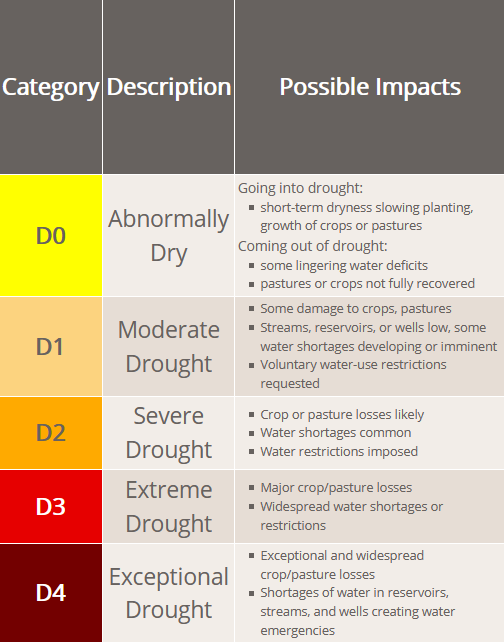

This is represented in the soil dataset by having no drought be NaN, and D0-D4 be in the range 1-5. To make this feature numeric, we cast the NaNs to a 0 and the other scores increase by 1. As no drought and D0 are not continuous, we also create a new IS_DROUGHT binary value to indicate the presence of drought.

In [ ]:
data['IS_DROUGHT'] = data['score'].apply(lambda x: 0 if np.isnan(x) else 1)
data['score'] = data['score'].apply(lambda x: 0 if np.isnan(x) else x+1)

We also drop the FIPS code and date from the drought information as it is redundant.

In [ ]:
data = data.drop(['fips', 'date'], axis=1)

The STATE is a string of 2 chars that represent the US state, for example CA = California. This is a categorical variable, so we one-hot encode it for use in the training of our models. We do this instead of dropping it as we believe that it can encode important information. For example, a fire in a state that is prone to fires (like California) may need to be prioritised.

In [ ]:
data = data.join(pd.get_dummies(data['STATE']))

In [ ]:
data.shape

(506954, 84)

Our final dataframe has over 500,000 records of fires, and 84 feature columns - truly Big Data!



#EDA

Before diving into developing models to predict the fire size class, we were keen to understand and explore patterns in our data.

Firstly, how serious is the wildfire problem? Is it growing? To answer this we summed the number of wildfires each year across all states in the USA and plotted them on a bar chart. We then overlayed this with a linear fit trendline.

As seen below, wildfires are clearly an increasing problem, with the number of wildfires literally doubling from the year 2000 to 2015. This supports the mission of our model to help firefighters understand and prioritize fires to fight - fire numbers may have doubled since 2000, but the number of firefighters hasn't!

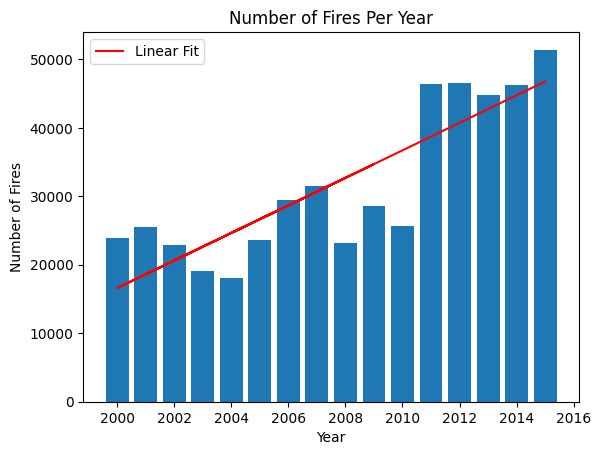

In [ ]:
from scipy.optimize import curve_fit

fires_per_year = data['FIRE_YEAR'].value_counts(sort=False)

plt.bar(fires_per_year.index, fires_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.title('Number of Fires Per Year')

def linear_func(x, a, b):
    return a * x + b

popt, _ = curve_fit(linear_func, fires_per_year.index, fires_per_year.values)

trend_line = linear_func(fires_per_year.index, *popt)

plt.plot(fires_per_year.index, trend_line, color='red', label='Linear Fit')
plt.legend()

plt.show()

We were also interested to do some sanity-checking on our data. When would we expect the most fires? During the warmest seasons in the United States; summer primarily. Categorizing the seasons and plotting them in a bar chart shows this holds true in our data set.

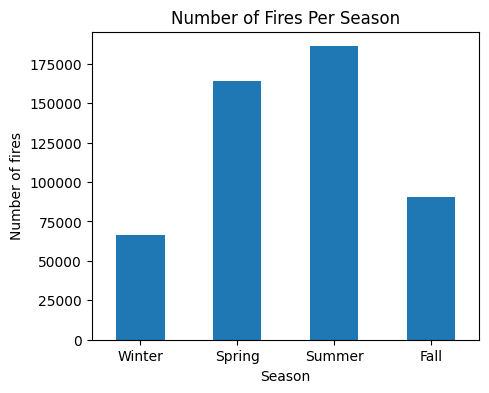

In [ ]:
plt.figure(figsize=(5, 4), dpi=100)
data["DISCOVERY_DATE"] = pd.to_datetime(data["DISCOVERY_DATE"], format="%Y-%m-%d")
data["SEASON"] = (data["DISCOVERY_DATE"].dt.month % 12 + 3)//3
fires_by_season = data.groupby("SEASON").size()
fires_by_season.plot(kind="bar", xticks=[0, 1, 2, 3], xlabel="Season", ylabel="Number of fires")
plt.xticks([0, 1, 2, 3], ["Winter", "Spring", "Summer", "Fall"], rotation=0)
plt.title('Number of Fires Per Season')
plt.show()

data = data.drop("SEASON", axis=1)

Another interesting aspect of wildfires that we explored was understanding the cause of wildfires. The dataset includes short descriptions on the origination of fires, potted below. As we can see, lightning and debris burning are the most significant contributors, but so are other causes such as arson. We then drop the text description of the fires, as we already have a STAT_CAUSE_CODE that numerically encodes this information.

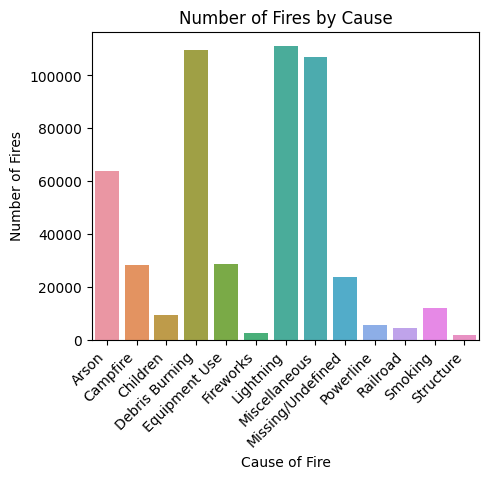

In [ ]:
plt.figure(figsize=(5, 4), dpi=100)
bar_count = data.groupby('STAT_CAUSE_DESCR').size().reset_index(name='Count')
sns.barplot(data=bar_count, x='STAT_CAUSE_DESCR', y='Count')
plt.title('Number of Fires by Cause')
plt.xlabel('Cause of Fire')
plt.ylabel('Number of Fires')
plt.xticks(rotation=45, ha='right')
plt.show()
data = data.drop("STAT_CAUSE_DESCR", axis=1)

Ultimatley our problem is a classification one - we want to predict the fire size class of a potential fire. As the plot below shows however, our dataset is highly imbalanced towards smaller fires - this makes sense as one would expect many small fires and fewer large ones.

Note that each of these classes correspond to an acre range:

A = greater than 0 but less than or equal to 0.25 acres
B = 0.26-9.9 acres
C = 10.0-99.9 acres
D = 100-299 acres
E = 300 to 999 acres
F = 1000 to 4999 acres
G = 5000+ acres

Size A fires are relatively minor - something that we explore later when we also try simplifying our problem to binary classification.

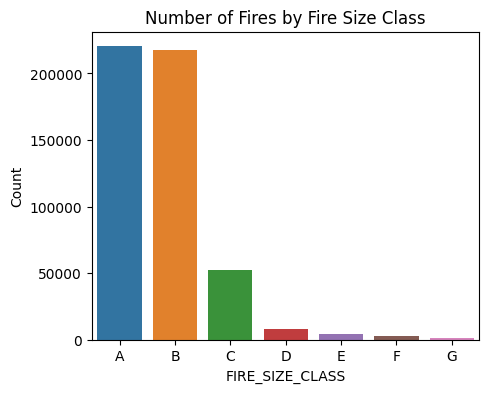

In [ ]:
plt.figure(figsize=(5, 4), dpi=100)

bar_count = data[['FIRE_SIZE_CLASS']]
bar_count = bar_count.groupby('FIRE_SIZE_CLASS').size().reset_index(name='Count')
sns.barplot(bar_count, x='FIRE_SIZE_CLASS', y='Count')
plt.title('Number of Fires by Fire Size Class')
plt.show()

California is infamously in the news for having awful wildfires over recent years, but in our dataset what US states have the most wildfires? We show this in a pie chart below (we consolidate any states that have less than 2.4% of the wildfires).

Interestingly the state of New York has the highest number of fires (but how big are they? See the next chart) at 13.4% of the records. California is in 3rd place.

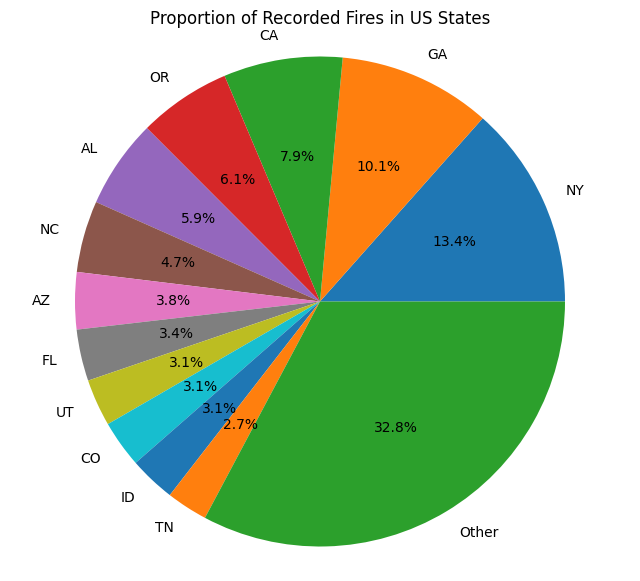

In [ ]:
plt.figure(figsize=(8, 7), dpi=100)

state_counts = data['STATE'].value_counts()

total = state_counts.sum()

threshold = 0.024 * total

# identify the states that account for less than the threshold and combine them into an "other" category
small_states = state_counts[state_counts < threshold].index.tolist()
state_counts['Other'] = state_counts[small_states].sum()
state_counts.drop(small_states, inplace=True)

plt.pie(state_counts.values, labels=state_counts.index, autopct='%1.1f%%')
plt.title('Proportion of Recorded Fires in US States')
plt.axis('equal')
plt.show()

New York having the most fires might be possible, but surely it doesn't have the largest fire area seeing as we don't hear about this in the news? That's exactly what we explored next. The statistics below use groupby and aggregation techniques from the course to find the average fire size for each state, as well as total the absolute number of fires.

We find that Nebraska has the largest fires on average, but only a few of these. As expected, whilst New York has the highest number of fires (over 68,000) they are on average the smallest (0.8 acres).

In [ ]:
state_stats = data.groupby('STATE').agg({'FIRE_SIZE': ['mean', 'count']})\
                .sort_values(by=('FIRE_SIZE', 'mean'), ascending=False)
state_stats.columns = ['Average Fire Size', 'Number of Fires']

print(state_stats.to_string())

       Average Fire Size  Number of Fires
STATE                                    
NE           1127.402558              129
ID            570.321153            15487
NV            566.582048            10057
TX            449.271220             8902
MT            248.464392            11325
WA            245.140202            10453
NM            240.895764            11211
WY            219.821110             5871
OR            177.824681            31009
UT            159.657066            15774
CA            150.589919            39797
ND            132.047506              405
AZ            114.632858            19070
VA            112.299925              796
OK             92.259775             8322
KS             69.401012             6010
CO             63.994199            15724
SD             61.334457             1032
LA             56.274136             1488
FL             45.874878            17225
MN             38.188348             5398
MO             36.518425          

Intrigued by the statistics in this table, we wanted to visualize this more clearly. To do this, we created a four quadrant plot where the x axis is the number of fires, and the y axis is the average fire size. We overlayed this with dotted lines representing the overall average fire size in the US and number of fires (averaged over all states). We plotted this logarithmically to avoid the data clumping in the lower left corner (i.e.: most states don't have many fires and they aren't that large on average).

The patterns here are illuminating. Take for example Nebraska - it is clear that it has only a few fires but they are on average the largest. This makes sense theoretically as Nebraska is a less populus and a state full of flat prarie grasslands (fires can spread widely).

The most concerning states are the ones in the top right quadrant - states with large fire sizes on average and a high number per year. We see a cluster of typically very hot states, such as California, Utah, Arizona etc. These are states that we hope our model will be most useful for.

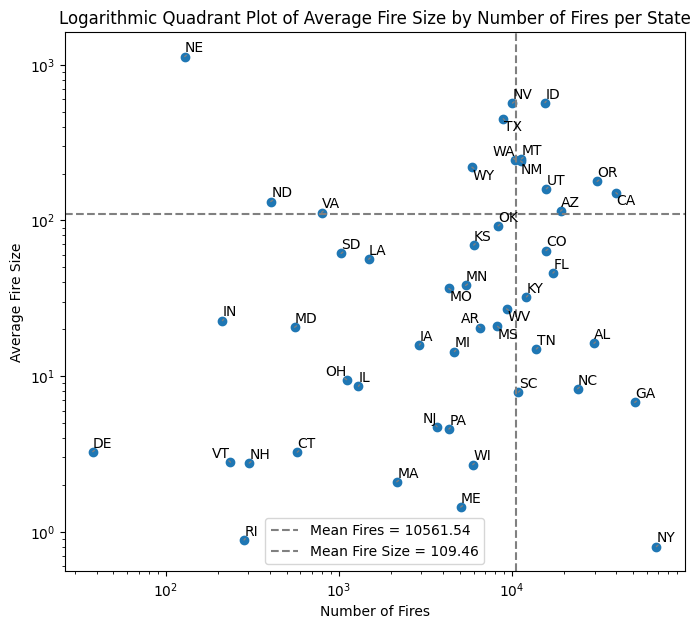

In [ ]:
plt.figure(figsize=(8, 7), dpi=100)

plt.scatter(state_stats['Number of Fires'], state_stats['Average Fire Size'])
plt.xscale('log')
plt.yscale('log')

mean_fires = state_stats['Number of Fires'].mean()
mean_fire_size = state_stats['Average Fire Size'].mean()

# Add the reference lines for the x and y axes
plt.axvline(x=mean_fires, color='gray', linestyle='--', label=f'Mean Fires = {mean_fires:.2f}')
plt.axhline(y=mean_fire_size, color='gray', linestyle='--', label=f'Mean Fire Size = {mean_fire_size:.2f}')

plt.xlabel('Number of Fires')
plt.ylabel('Average Fire Size')
plt.title('Logarithmic Quadrant Plot of Average Fire Size by Number of Fires per State')

plt.legend()

# Add state labels to each point on the plot and store the text objects in the list
texts = []
for state, row in state_stats.iterrows():
    texts.append(plt.text(row['Number of Fires'], row['Average Fire Size'], state))

# Adjust the state label positions to avoid overlapping using adjustText
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.show()


Finally we plotted a correlation map of the numeric features in our dataframe, to get an idea of what features are related and to shape the methods we use. Naturally, many of the drought indicators are highly correlated - we would expect this. For example, the temperature at 2m is likely to be directly related to the Earth skin temperature. We don't plot our one-hot encoded state columns here, of course.

<ipython-input-23-93e4b835e46f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_subset.corr()


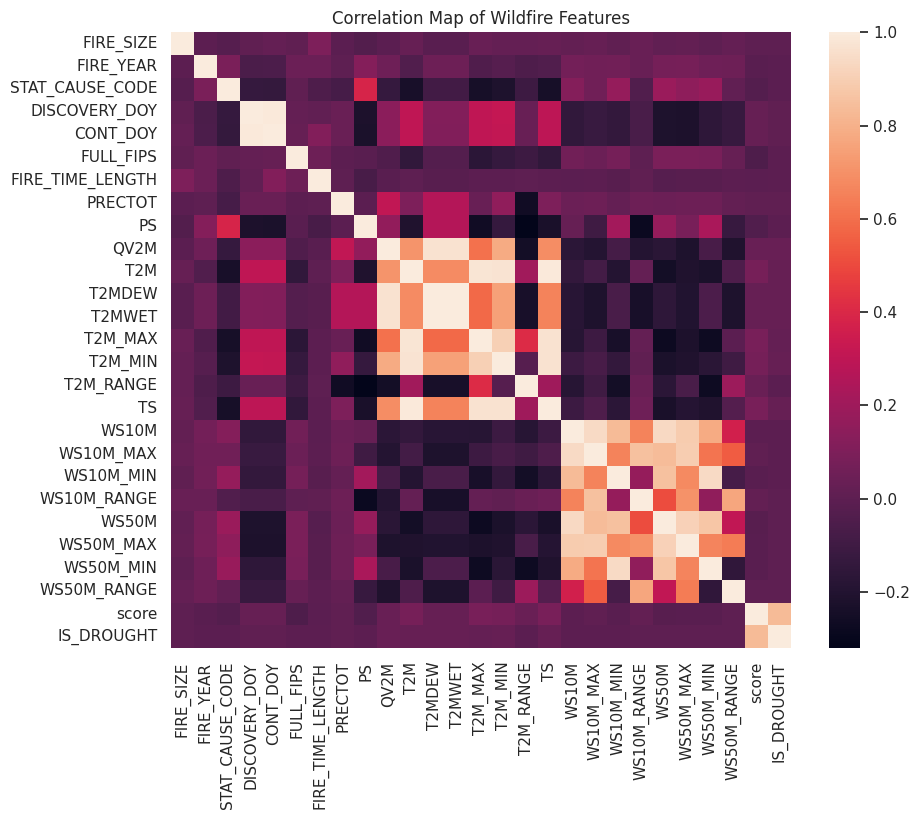

In [ ]:
data_subset = data.drop(data.columns[35:], axis=1)
corr = data_subset.corr()
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(corr)
plt.title('Correlation Map of Wildfire Features')
plt.show()

# Multi-class Fire Size Classification: Classical ML Methods

Now, to the models! The first problem we have tried to solve is multi-class classification. Given all of the details of a fire, can we predict the exact class that the final fire size will be?

For this section, we will be training 4 classical machine learning algorithms and comparing their performance with predicting the size of a wildfire. The labels we are using for this is the 'Fire Size Class' column explained in Preprocessing section.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from imblearn.over_sampling import SMOTE

We continue by integer encoding the labels, splitting the dataset to a train and test set, and scaling the dataset with StandardScaler.

Naturally we drop our target column, as well as datetime columns (as we already have an integer day-of-year, DOY column). We also drop the containment days, as we have created another column for fire length. Keeping these would increase the multicollinearity of our dataset - something that is undesirable in machine learning, and wasteful for training our classifiers.

In [ ]:
# Dropping features which are linear combinations of each other or are
# strings and cannot be used for machine learning.
features = data.drop(["STATE", "FIRE_SIZE_CLASS", "FIRE_SIZE", 'DISCOVERY_DATE', "CONT_DATE", "CONT_DOY", "DISCOVERY_TIME", "CONT_TIME", "fips_state"], axis=1)
labels_letters = data["FIRE_SIZE_CLASS"].array

# Encoding fire size classes into numbers. A-G to 0-6
le = preprocessing.LabelEncoder()
le.fit(labels_letters)
labels_encoded = le.transform(labels_letters)

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.20, random_state=42)

# Scale the features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.astype(int)

The below function is used for reports the accuracy, precision, recall, and F1 score for a given model. It also produces a confusion matrix for easy visualization of our predictions versus the test set labels.

As our data is imbalanced, it is important for us to judge the performance of our models on more than just accuracy. High accuracy does not factor in precision and recall, whereas the F1 score does. By displaying a small confusion matrix when evaluating each model, we are also able to see what classes our model is incorrectly classifying - allowing us to hone our methods.

In [ ]:
def eval(y_true, y_pred, name, binary=False):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')
  cm = confusion_matrix(y_true, y_pred)

  print("Accuracy: {:.2f}".format(accuracy))
  print("Precision: {:.2f}".format(precision))
  print("Recall: {:.2f}".format(recall))
  print("F1 Score: {:.2f}".format(f1))

  if 'Binary' in name:
    binary = True

  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True, linewidths=0.01, linecolor="gray")
  if binary:
    ticks = ['A', 'Not A']
  else:
    ticks = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
  plt.xticks(np.arange(cm.shape[0]) + cm.shape[0]/len(ticks)/2, labels=ticks)
  plt.yticks(np.arange(cm.shape[0]) + cm.shape[0]/len(ticks)/2, labels=ticks)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title(name + " \nConfusion Matrix")
  plt.show()

This function plots the training accuracy over the number of epochs for the neural networks we will be designing later.

In [ ]:
def nn_eval(accuracies, epochs, name):
  plt.figure(figsize=(5,3))
  plt.plot(np.arange(1, len(accuracies)+1), accuracies)
  plt.xticks(np.arange(0, 11)*epochs/10)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training Accuracy vs Epochs for\n' + name)

## Logistic Regression Classifier

This is a Logistic Regression Classifier. This simple probabilistic method forms our baseline, using the softmax function for multi-class classification.

For all of the classical models, we will be using the sklearn library. This classifier is then fit on the `X_train` and `y_train` that were defined in the previous train test split. The previously described `eval` function is called on the testing results to visualize our model performance.

The Logistic Regression classifier performed moderately well. As will be seen with later models, this model had a distinct propensity to predict a lower class fire than reality. This can be seen in the confusion matrix. 

We believe that this is due to the class imbalance - something that we will later address with SMOTE.

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.62
Precision: 0.56
Recall: 0.62
F1 Score: 0.57


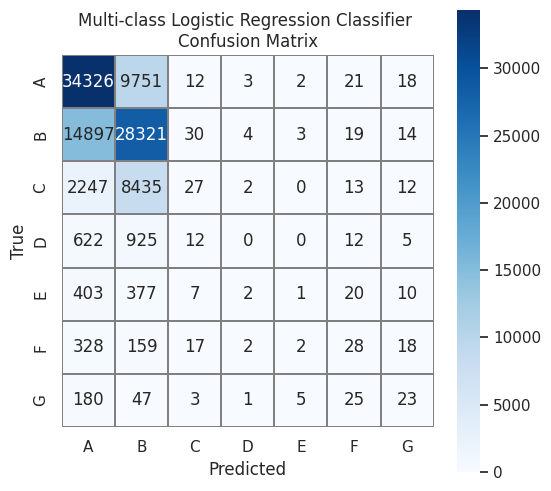

In [ ]:
# Logistic Regression Classifier
lg_clf = LogisticRegression()
lg_clf.fit(X_train, y_train)
y_pred_lg = lg_clf.predict(X_test)
eval(y_test, y_pred_lg, "Multi-class Logistic Regression Classifier")

## Decision Tree Classifier

Below is our basic decision tree classifier, which is once again pulled from the sklearn library. Decision trees are a form of explainable ML that greedily maximize information gain at each division - partitioning the decision space to make a final predicition.

As with all of our models, this classifier is fit on the `X_train` and `y_train` that were defined in the train test split. The `eval` function is called on the testing results to visualize our model performance.

The model performed somewhat worse than the logistic regression model, and still suffers from the same propensity to underestimate the severity of fires. While typically decision trees are better than logistic regression, they can be more prone to overfitting. 

Decision trees can be regularized to reduce the chance of overfitting, usually by pruning or setting a maximum depth. Options for this are provided in sklearn. We did do a grid search over hyperparameters here, but unfortunatley found that (after a very long training time) no significant improvement, and we condensed this into the section below this to explore our results.

Accuracy: 0.59
Precision: 0.58
Recall: 0.59
F1 Score: 0.58


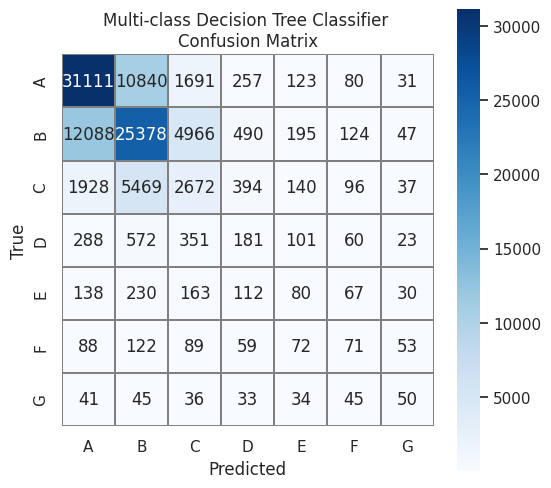

In [ ]:
# Decision Tree Classifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
eval(y_test, y_pred_tree, "Multi-class Decision Tree Classifier")

## Adaboost Classifier

Below is Adaboost classifier, which is once again pulled from the sklearn library. Adaboost is an extension of the decision tree algorithm - specifically, it is an ensemble of decision trees. It fits further trees to residuals, attempting to improve performance. However, during this training it runs the risk of overfitting to the errors.

As with all of our models, this classifier is fit on the `X_train` and `y_train` that were defined in the train test split. The `eval` function is called on the testing results to visualize our model performance.

This model had similar performance as the basic decision tree classifier, and once again suffered from underestimation. This suggests to us that fitting additional trees to the residual error is not an effective method of increasing performance, and it is likely overfitting as we theorized - and even more than the already overfit standard decision tree above!

Accuracy: 0.58
Precision: 0.56
Recall: 0.58
F1 Score: 0.55


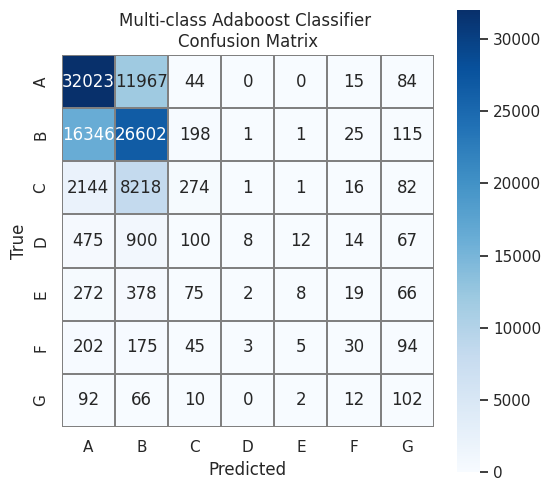

In [ ]:
# Adaboost Classifier
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_train, y_train)
y_pred_ab = ab_clf.predict(X_test)
eval(y_test, y_pred_ab, "Multi-class Adaboost Classifier")

## Random Forest Classifier

Below is our Random Forest classifier, pulled from the sklearn library. The RFC is another extension of the decision tree classifier. We expect RFC to do better than other classical methods as it is an ensemble, while Adaboost typically provides more accurate predictions than RFC, we see above that Adaboost is also more sensitive to overfitting.

As with all of our models, this classifier is fit on the `X_train` and `y_train` that were defined in the train test split. The `eval` function is called on the testing results to visualize our model performance.

The Random Forest Classifier performed the best out of our classical models. However, it still falls victim to the issue shared by the previous models - it is highly biased to predicting smaller fires and is not capable of accurately predicting severe fires.

This issue is so prevelant in our models that it is clearly to do with class imbalance of our dataset - read ahead to the SMOTE section to see how this improves!

Accuracy: 0.65
Precision: 0.63
Recall: 0.65
F1 Score: 0.63


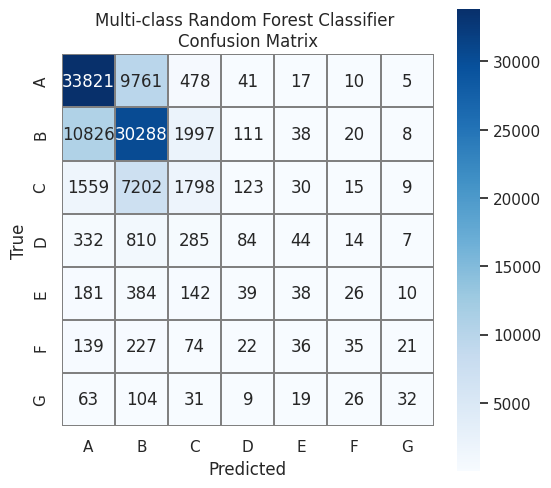

In [ ]:
# Random Forest Classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
eval(y_test, y_pred_rf, "Multi-class Random Forest Classifier")

## Varying Hyperparameters
Before we move forward to other methods, we would like to explore some hyperparameters of our best classifier to see if we can improve the performance at all. For this, we will vary the max depth of the tree as well as the number of estimators. We will also try different criterion, such as log loss and gini. 

Below is the result of one of our experiments. As you can see, the accuracy, precision, recall and f1 scores are the same/similar to our original Random Forest Classifier. This rings true for other combinations of hyperparameters as well. We varied `n_estimators` from 50 to 200, `max_depth` from 15 to 50, and we tried each available criterion for loss. Unfortunately, we were not able to significantly improve the performance of our model.

Accuracy: 0.65
Precision: 0.63
Recall: 0.65
F1 Score: 0.63


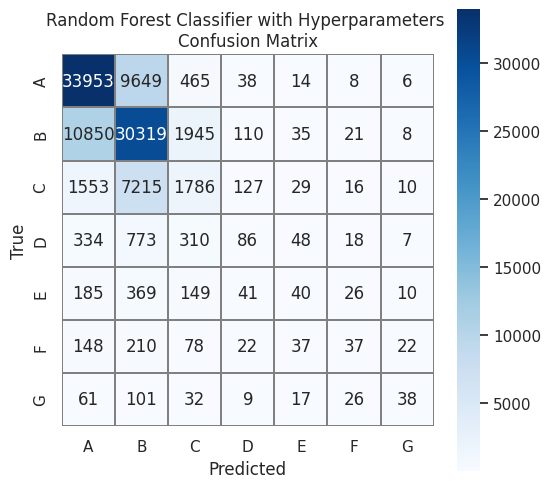

In [ ]:
# Random Forest Classifier with hyperparameters
rf_clf_hyp = RandomForestClassifier(n_estimators=150, max_depth=40, criterion="log_loss")
rf_clf_hyp.fit(X_train, y_train)
y_pred_rf = rf_clf_hyp.predict(X_test)
eval(y_test, y_pred_rf, "Random Forest Classifier with Hyperparameters")

## Principal Component Analysis on RFC
Separately, and primarily because our models took a long time to train, we were interested in understanding the variance in our data with respect to the features, and decided to retrain our most promising model with PCA.

In [ ]:
from sklearn.decomposition import PCA

The sklearn PCA method is fit to our `X_train`. Similar to what we have done in HW4, we analyzed and plotted how the Cumulative Explained Variance Ratio increased as we increased the number of features in our PCA. As is visible on the plot, our data is highly complex and greatly varies across our features. We do not have a suffiently explained variante ratio until we account for 42 features - the majority of our feature set. This can suggest that each feature is highly important towards affecting the outcome of our models.

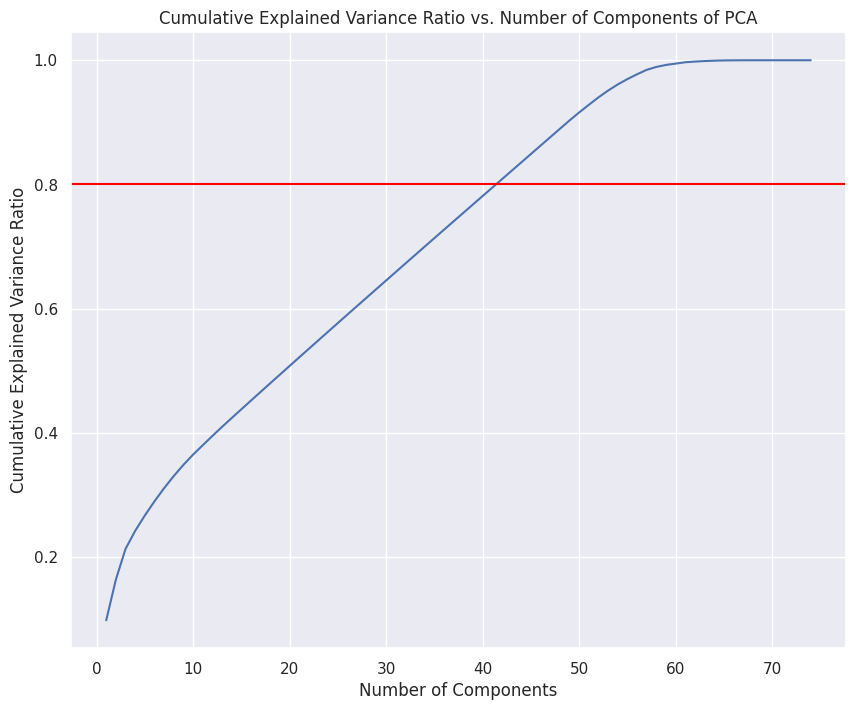

In [ ]:
pca = PCA()
pca.fit(X_train)
explained_variance_ratios = pca.explained_variance_ratio_

cum_evr = [explained_variance_ratios[0]]
for i in range(len(explained_variance_ratios)-1):
  cum_evr.append(sum(explained_variance_ratios[:i+2]))

plt.plot(range(1,(len(cum_evr)+1)), cum_evr)
plt.axhline(0.8, color='red')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components of PCA')
plt.show()

Here we perform PCA on our train and test set with the number of components determined to account for 80% of our explained variance.

In [ ]:
pca = PCA(n_components=42)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

We decided to only train our Random Forest classifier on the PCA dataset since that perfomed the best our of our classical models. 

Accuracy: 0.64
Precision: 0.61
Recall: 0.64
F1 Score: 0.62


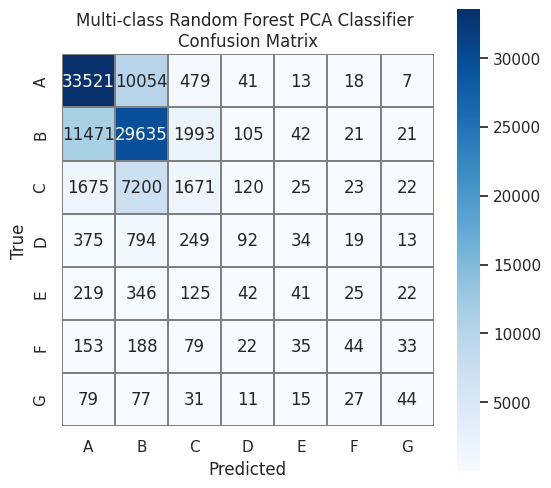

In [ ]:
rf_clf_3 = RandomForestClassifier()
rf_clf_3.fit(X_train_pca, y_train)
y_pred_pca = rf_clf_3.predict(X_test_pca)
eval(y_test, y_pred_pca, "Multi-class Random Forest PCA Classifier")

From these results produced, it is evident that PCA is neither helpful nor necessary for our dataset. Additionally, based on the plot of the cumulative explained variance ratio vs. the number of components, we can come to the conclusion that most features are equally relevant, since the line semi-linearly increases from 10 features to 50 features.

This means that almost every additional feature describes the variance more and more.

## RFC with Multi-class SMOTE

Motivated by our thoughts on class imbalance, we decided to experiment with oversampling our data.

SMOTE stands for Syntheric Minority Oversampling Technique. This library is used for resampling a dataset in which the target labels are highly imbalanced. It synthesizes new samples by taking a point from an under-represented label, finding a random nearest neighbor, and creating a new sample at a random point between the inital point and the chosen neighbor. For our purposes, it will resample the dataset such that fire classes C through G have equal representation. Through using this, we hope to better train our models so that they avoid the bias towards class A and B seen in the confusion matrices in previous parts.

We use the imblearn library for our SMOTE method. It is fit to our X_train and y_train and resamples the data as previously described.

In [ ]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
# Don't need to rescale because X_train and y_train are already standardized

Once again, we only run the Random Forest Classifier on the resampled dataset since it performed the best our of our classical models, and to save space in our notebook!

Notably, our accuracy took a slight decrease. However, based on the confusion matrix, the propensity to underestimate the severity of fires has been significantly reduced since the bottom left portion of the confusion matrix is more balanced with the top right side.

This makes a lot of sense as the classes are now properly balanced (even with the dummy data).

Accuracy: 0.63
Precision: 0.63
Recall: 0.63
F1 Score: 0.63


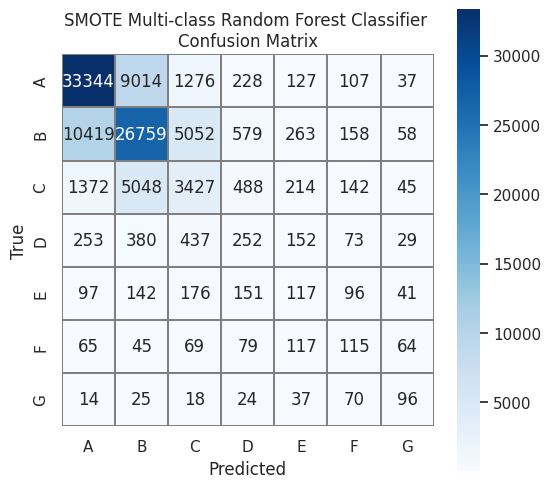

In [ ]:
# Random Forest Classifier with SMOTE
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
eval(y_test, y_pred_rf, "SMOTE Multi-class Random Forest Classifier")

# Multi-class Fire Size Classification: Neural Network

In addition to classical machine learning methods, we also tried using Neural Networks to make multi-class predictions. The intuition behind this was that the classical models did not have the complexity to accurately classify each fire size class, so a multi-stage neural network could potentially learn more from the features and thus make more accurate predictions.

## Without SMOTE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from imblearn.over_sampling import SMOTE
!pip install torchviz
from torchviz import make_dot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=7c949cceea8ba2ef6b3e6254aa6dfd9057991f063c373966fbc5b614b9cf37ed
  Stored in directory: /root/.cache/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


First, we preprocess the data we have to remove categorical data and the target variable. Additionally, we map the fire size classes to numerical labels to integrate the data better with the neural net model, then split the data into training and testing sets, passing both through a standard scaler.

In [ ]:
data_nn = data.drop(['STATE', 'FIRE_SIZE', 'fips_state'], axis=1)

In [ ]:
fire_size_class_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
data_nn['FIRE_SIZE_CLASS'] = data_nn['FIRE_SIZE_CLASS'].map(fire_size_class_mapping)

data_nn = data_nn.drop(['CONT_DATE', 'DISCOVERY_DATE'], axis=1)
data_nn = data_nn.dropna()
print(data_nn.shape)

(457941, 78)


In [ ]:
# Split the dataset into features and target columns
features = data_nn.drop(['FIRE_SIZE_CLASS'], axis=1)
target = data_nn['FIRE_SIZE_CLASS']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In the cell below we define a helper FireDataset for use in Pytorch, and also define a FireSizePredictor that describes our neural network structure.

While we tried multiple network structures, the one that we settled on below balanced a relatively simple but powerful structure. It is formed of 3 fully connected layers: an input layer, hidden layer and output layer. These are seperated by the non-linearity provided by the ReLU.

We experimented and added a dropout layer too. This dropout layer disconnects 50% of the connections from the first layer for each training, and we use this as a form of regularization.

In [ ]:
class FireDataset(Dataset):
  def __init__(self, features, targets):
    self.features = torch.tensor(features, dtype=torch.float32)
    self.targets = torch.tensor(np.array(targets).astype(np.int64), dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    return self.features[idx], self.targets[idx]

class FireSizePredictor(nn.Module):
  def __init__(self, input_size, output_size, dropout_prob=0.5):
    super(FireSizePredictor, self).__init__()
    self.network =  nn.Sequential(
                      nn.Linear(input_size, 128),
                      nn.ReLU(),
                      nn.Dropout(dropout_prob),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, output_size)
                    )

  def forward(self, x):
    return self.network(x)

In [ ]:
batch_sz = 256
train_dataset = FireDataset(X_train, y_train)
test_dataset = FireDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_sz, shuffle=False)

A visualization of our final network can be seen below, with the different parameters and layer shapes:

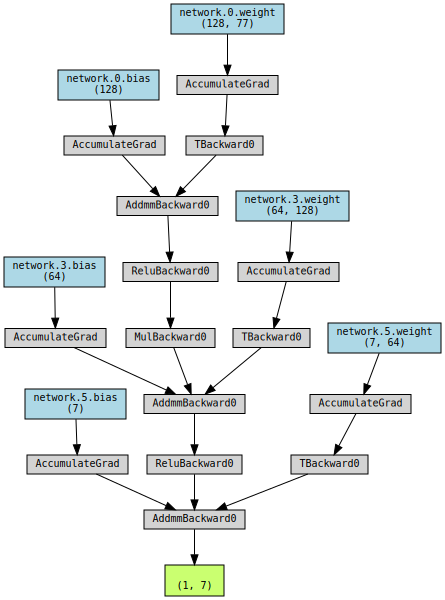

In [ ]:
input_size = X_train.shape[1]
output_size = len(fire_size_class_mapping)
model = FireSizePredictor(input_size, output_size)

x = torch.randn(1, input_size)
make_dot(model(x), params=dict(model.named_parameters()))

We define a function that trains the neural network provided with the training Dataloader provided, graphs the training accuracy over the chosen amount of epochs, creates a confusion matrix from the neural networks' predictions on the testing Dataloader provided, and displays the various metrics of the confusion matrix. We used Cross Entropy Loss for all of our neural networks due to the categorical nature of the problem we are trying to solve.

In [ ]:
def run_nn(model, epochs, train_loader, test_loader, name):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  device = torch.device("cuda")
  model.to(device)

  accuracies = []

  for epoch in range(epochs):
    correct = 0
    total = 0
    running_loss = 0.0
    for batch_idx, (input, target) in enumerate(train_loader):
      input, target = input.to(device), target.to(device)
      
      optimizer.zero_grad()
      output = model(input)
      loss = criterion(output, target)
      
      running_loss += loss.item()
      prediction = torch.argmax(output.data, dim=1)

      loss.backward()
      optimizer.step()
      
      correct += (target==prediction).sum().item()
      total += target.size(0)
    accuracy = correct / total * 100
    accuracies.append(accuracy)

  nn_eval(accuracies, epochs, name + " Neural Net")

  true_labels = []
  predicted_labels = []

  with torch.no_grad():
    for batch_features, batch_targets in test_loader:
      batch_features = batch_features.to(device)
      batch_targets = batch_targets.to(device)
      
      outputs = model(batch_features)
      _, predicted = torch.max(outputs.data, 1)
          
      true_labels.extend(batch_targets.cpu().numpy())
      predicted_labels.extend(predicted.cpu().numpy())

  eval(true_labels, predicted_labels, name + " Neural Network Classifier")

Accuracy: 0.67
Precision: 0.65
Recall: 0.67
F1 Score: 0.65


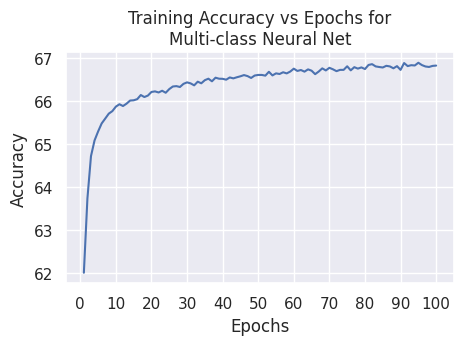

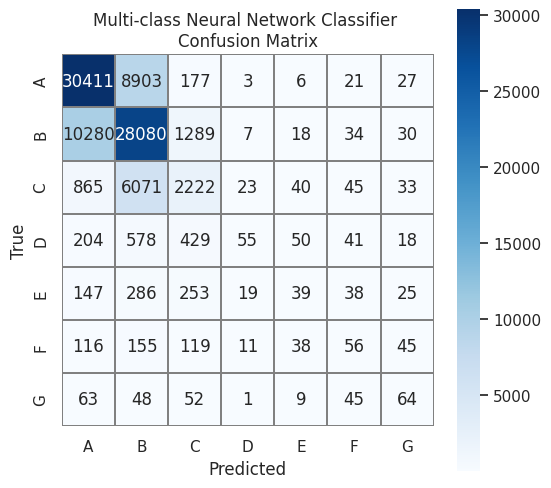

In [ ]:
run_nn(model, 100, train_loader, test_loader, "Multi-class")

As seen from the results above, applying and training a neural network on our multi-class classification provided results that were similar to the performance of classical models, and relatively poor.

Overall accuracy and F1 score are around the 65% mark, dominated by the many correct predictions for Class A and B. Our model becomes much more worrying when you look at the confusion matrix for a serious category of fire like Class G - the network predicted that 63 Class G fires were Class A - a grave mistake! Again, this is most likely to do with the class imbalance problem.

As before, we wondered whether this performance could be improved by upsampling our lower classes with SMOTE.

## With SMOTE

Similar to the Random Forest Classifier, we wanted to see if implementing SMOTE to even out the heavy class imbalance between fire size classes A and B and the rest of the classes would mitigate the overclassification of A and B over the other classes with fewer instances.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from imblearn.over_sampling import SMOTE

In [ ]:
# Split the dataset into features and target columns
features = data_nn.drop(['FIRE_SIZE_CLASS'], axis=1)
target = data_nn['FIRE_SIZE_CLASS']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Scale the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
batch_sz = 256
train_dataset = FireDataset(X_train, y_train)
test_dataset = FireDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_sz, shuffle=False)

In [ ]:
input_size = X_train.shape[1]
output_size = len(fire_size_class_mapping)
model = FireSizePredictor(input_size, output_size)

Accuracy: 0.58
Precision: 0.63
Recall: 0.58
F1 Score: 0.60


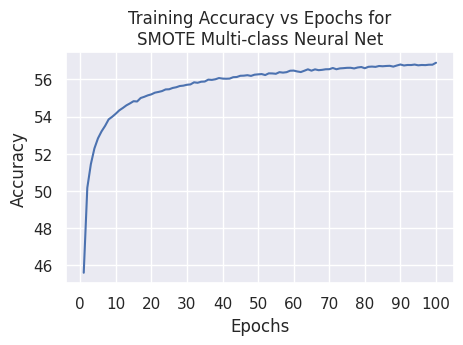

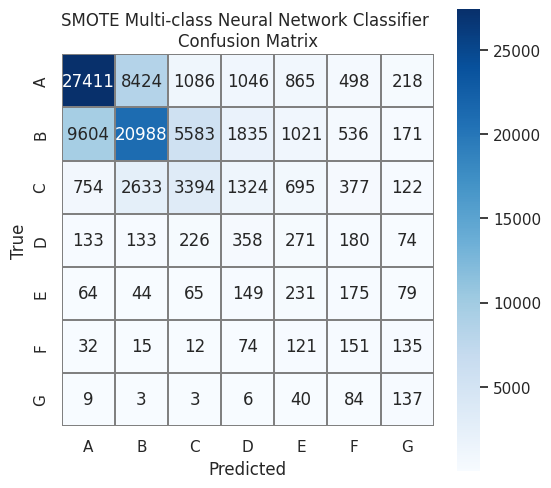

In [ ]:
run_nn(model, 100, train_loader, test_loader, "SMOTE Multi-class")

After 100 epochs of training this model, the impact of balancing the classes is interesting. Examining the confusion matrix shows that for the extreme classes, such as Class G, the predictions are closer to the correct class, but still largely incorrect (potentially by 100s-1000s of acres).

In fact, the overall performance of the network has decreased by all measures including accuracy, F1 score, precision and recall. However, inspecting the confusion matrix shows that predictions are much more closely clustered to their true class. This is because the dataset that we are using provides categorical labels for fire size - but these categories are related to each other (as they are a binned range). 

So, even though on paper this model is worse than the previous, the confusion matrix illuminates that it is probably far more useful in real life. If there is a Class C fire, it is better to estimate that it is a Class B or D, rather than a Class G!

# Binary Fire Size Classification: Classical ML Methods

Motivated by the the poor performance, to make our model more useful we also present work towards a binary classification model.

If our model was to be deployed in the field, we theorize that firefighters could be interested in a simple binary decision of whether a fire is worth addressing. Size A fires are very small, less than 0.25 acres. Since this size of fire is not that severe, we will retrain our models on a binary classification of Class A or not Class A.

In [ ]:
# Dropping features which are linear combinations of each other or are
# strings and cannot be used for machine learning.
features = data.drop(["STATE", "FIRE_SIZE_CLASS", "FIRE_SIZE", 'DISCOVERY_DATE', "CONT_DATE", "CONT_DOY", "DISCOVERY_TIME", "CONT_TIME", "fips_state"], axis=1)
labels_letters = data["FIRE_SIZE_CLASS"].array

# Encoding fire size classes into numbers. A-G to 0-6
le = preprocessing.LabelEncoder()
le.fit(labels_letters)
labels_encoded = le.transform(labels_letters)
labels_encoded = np.array(list(map(lambda x: 1 if x > 0 else x, labels_encoded)))

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.20, random_state=42)

# Scale the features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.astype(int)

We proceed with using the same classifiers that were used for the multi-class fire size classification.

For brevity, we have not included descriptions on these classifiers as they are the same as the multi-class case. 

## Logistic Regression Classifier

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.73
Precision: 0.73
Recall: 0.73
F1 Score: 0.73


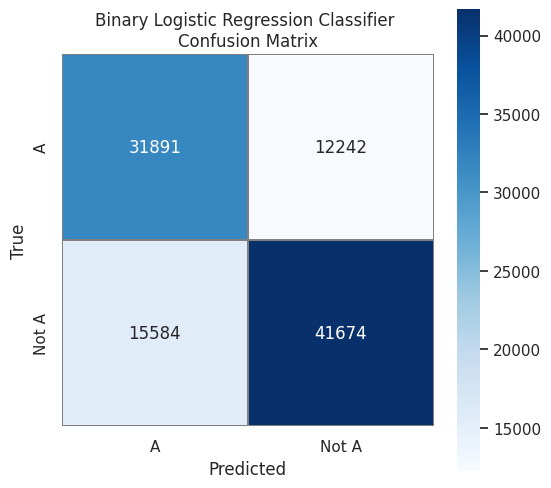

In [ ]:
# Logistic Regression Classifier
lg_clf = LogisticRegression()
lg_clf.fit(X_train, y_train)
y_pred_lg = lg_clf.predict(X_test)
eval(y_test, y_pred_lg, "Binary Logistic Regression Classifier")

Already we are encouraged by much better performance, with our metrics being 73% round the board. If you also consider the graph of the number of samples in each class in our EDA, you will see that A and "Not A" total to roughly the same number of labels, and our model has not learnt from any imbalance as a result.

## Decision Tree Classifier

Accuracy: 0.73
Precision: 0.73
Recall: 0.73
F1 Score: 0.73


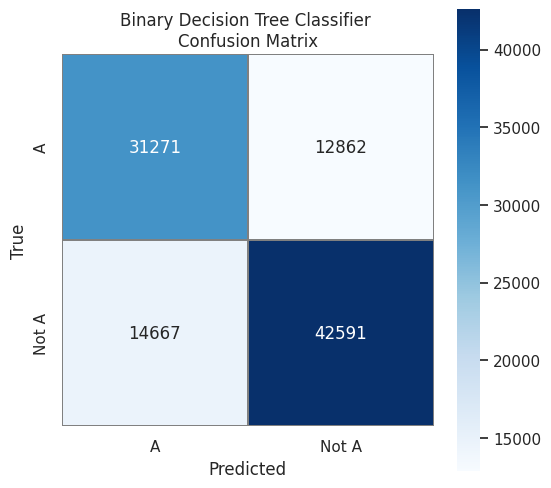

In [ ]:
# Decision Tree Classifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
eval(y_test, y_pred_tree, "Binary Decision Tree Classifier")

Again, the decision tree is also much better. Binning categories together can actually be thought of as a form of regularization [3]:

"The main motivation of binning is to make the model more robust and prevent overfitting, however, it has a cost to the performance. Every time you bin something, you sacrifice information and make your data more regularized."

As our original decision tree classifiers had worse performance due to suspected overfitting, the increase here makes a lot of sense.

\[3]: https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114

## Adaboost Classifier

Accuracy: 0.74
Precision: 0.74
Recall: 0.74
F1 Score: 0.74


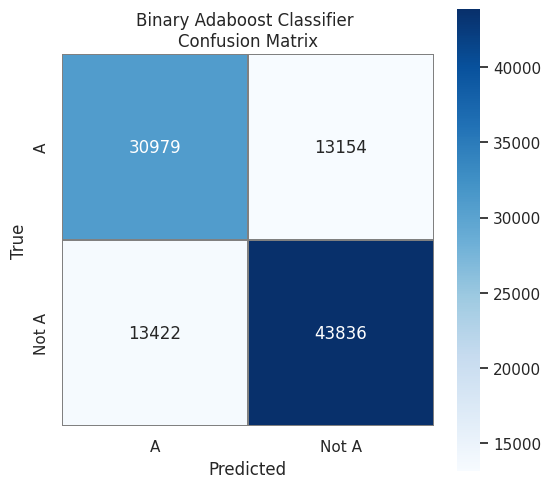

In [ ]:
# Adaboost Classifier
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_train, y_train)
y_pred_ab = ab_clf.predict(X_test)
eval(y_test, y_pred_ab, "Binary Adaboost Classifier")

A marginal increase on our decision tree classifier, suggesting that some performance can be eeked out by fitting further trees to the residual errors!

## Random Forest Classifier

Accuracy: 0.78
Precision: 0.78
Recall: 0.78
F1 Score: 0.78


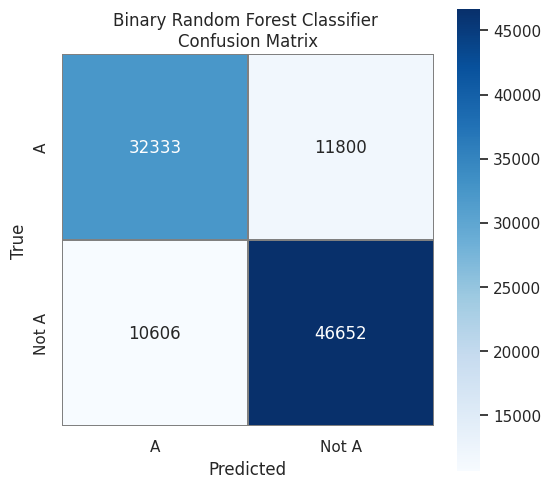

In [ ]:
# Random Forest Classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
eval(y_test, y_pred_rf, "Binary Random Forest Classifier")

Again we see that the Random Forest Classifier captures the most predictive power here and classifies with 78% across all of the metrics. This performance is significantly better than our previous multi-class experiments!

## RFC with Binary SMOTE

We also wanted to see the effects of SMOTE on this binary classification with the RFC. Hyptothetically, this should not increase accuracy by any significant amount, as changing the label to a binary classification mitigates most of the class imbalance.

In [ ]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

Accuracy: 0.78
Precision: 0.78
Recall: 0.78
F1 Score: 0.78


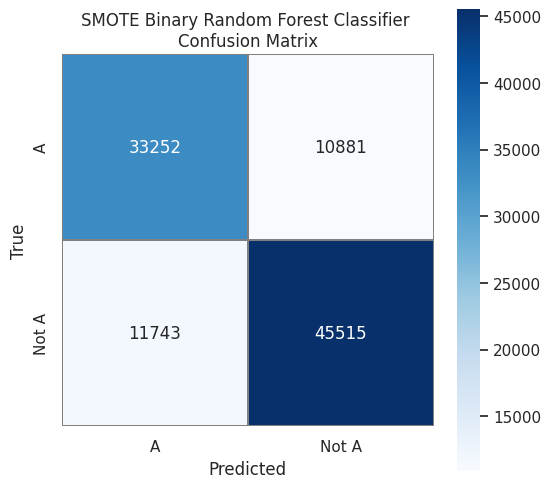

In [ ]:
# Random Forest Classifier with SMOTE
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
eval(y_test, y_pred_rf, "SMOTE Binary Random Forest Classifier")

Unsurprisingly there has been little effect on the performance, as the binned classes A and "Not A" are already almost balanced.

# Binary Fire Size Classification: Neural Network

Similar to the Multi-Class section, we wanted to see if a neural network could capture more complexity from the data when making a binary classification on the data.

### Without SMOTE

Again, we preprocess the data we have to remove categorical data and our target variable. Additionally, we map the fire size classes to numerical labels to integrate the data better with the neural net model, then split the data into training and testing sets, passing both through a standard scaler. This time, the mapping groups every class besides A together to change the multi-class labels into binary labels.

In [ ]:
data_nn = data.drop(['STATE', 'FIRE_SIZE', 'fips_state'], axis=1)
fire_size_class_mapping = {'A': 0, 'B': 1, 'C': 1, 'D': 1, 'E': 1, 'F': 1, 'G': 1}
data_nn['FIRE_SIZE_CLASS'] = data_nn['FIRE_SIZE_CLASS'].map(fire_size_class_mapping)

data_nn = data_nn.drop(['CONT_DATE', 'DISCOVERY_DATE'], axis=1)
data_nn = data_nn.dropna()
print(data_nn.shape)

(457941, 78)


In [ ]:
# Split the dataset into features and target columns
features = data_nn.drop(['FIRE_SIZE_CLASS'], axis=1)
target = data_nn['FIRE_SIZE_CLASS']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
batch_sz = 256
train_dataset = FireDataset(X_train, y_train)
test_dataset = FireDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_sz, shuffle=False)

In [ ]:
input_size = X_train.shape[1]
output_size = 2
model = FireSizePredictor(input_size, output_size)

Accuracy: 0.78
Precision: 0.78
Recall: 0.78
F1 Score: 0.78


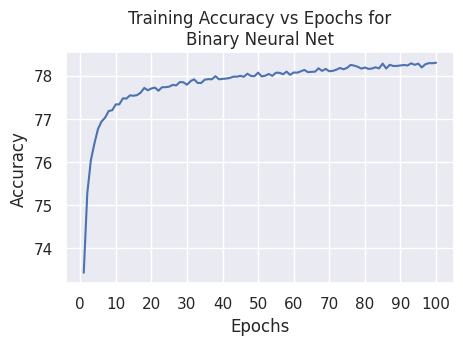

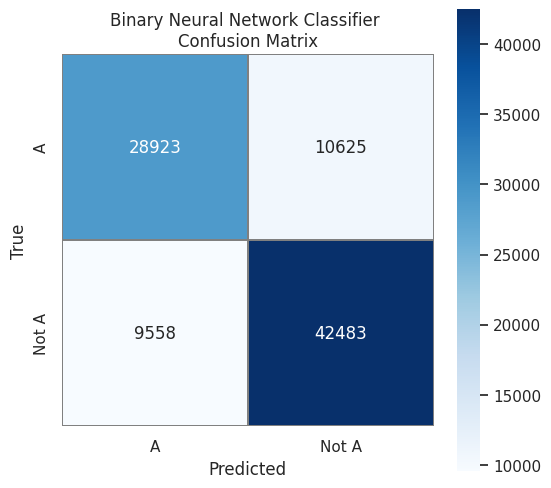

In [ ]:
run_nn(model, 100, train_loader, test_loader, "Binary")

And again, excellent performance that is very close to (just exceeds) that of the Random Forest Classifier. Both models can capture significant non-linear and complex information (they are the most complex out of any that we tried).

From our training accuracy graph you can see that there does seem to be a little more that could be gained from additional epochs, and we experimented with this. However, when increasing the number of epochs we actually found that model performance decreased. This is because the model started to overfit to the training set, and reducing the epoch number is a form of regularization called "early stopping".

### With SMOTE

We also wanted to see the effects of SMOTE on this binary classification with the neural network - just like with Binary RFC with SMOTE, we did not expect a significant performance difference, and didn't find one.

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Scale the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
batch_sz = 256
train_dataset = FireDataset(X_train, y_train)
test_dataset = FireDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_sz, shuffle=False)

In [ ]:
input_size = X_train.shape[1]
output_size = 2
model = FireSizePredictor(input_size, output_size)

Accuracy: 0.78
Precision: 0.78
Recall: 0.78
F1 Score: 0.78


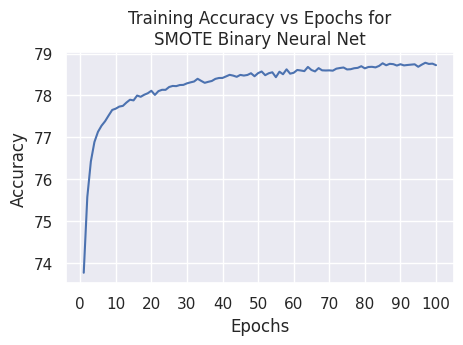

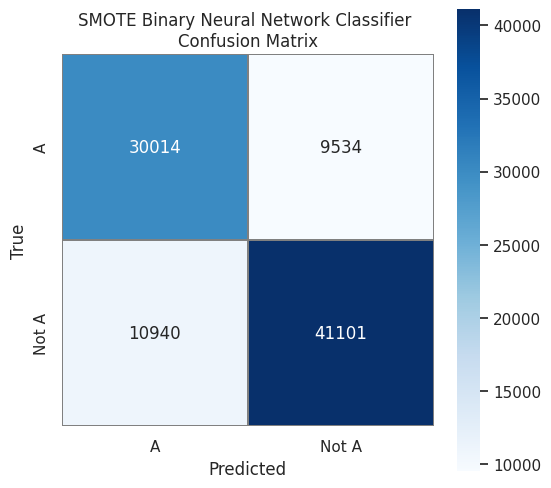

In [ ]:
run_nn(model, 100, train_loader, test_loader, "SMOTE Binary")

# Conclusions

**At the end of this project we have developed an almost 80% accurate/precise model that could be deployed in the field with firefighters for them to prioritize what fires to tackle.** In the process we have learnt a huge amount and applied many of the concepts from the Big Data course. As well as the content in this notebook, we experimented with many other models and methodologies - but present the best here in the most coherent order possible :)

For the binary classification models, our accuracy is much higher in comparison to the multi-class classification models. Additionally, this avoids the large bias seen in the confusion matrices in the multi-class models due to heavy class imbalance.

Through experimenting with PCA, we discovered that the variance explained by the features in our data increases semi-linearly as you increase the number of features in PCA. Therefore, we can come to the conclusion that the features in our data are mostly equally important to determining the size of the fire.

Based on our experiments with the SMOTE algorithm, we have come to the conclusion that this method of rebalancing data is largely not effective when judging the performance of models by common metrics, but is useful when examining their confusion matrices.

After using many different types of classification models and data sampling, our model accuracy never reached >80%. Therefore, we theorize the data we have used to predict fire size is not wholly indicative of the range that a wildfire will reach.

## Future Work

For future work on this subject, a wider range of datasets should be considered as there may be data that is much more indicative of the size of a fire. As many of our models reached a similar level of accuracy/F1 score in the binary classification, we believe that additional features may be the way of improving our performance.

For example, the "discovery day" feature is only when the fire was discovered - this could potentially be some time after the fire started. A backdated origination date could be useful for training. Equally, our drought information is relatively coarse - on the county level - whereas a wildfire may break out only in a subset of the county. More granular drought information could be useful here.

Additionally other completely new features may be useful, such as UV index of that area of the day. Population density and the number of firefighters may directly correlate to the length and size of a fire. Some sort of vegetation index could also be useful information to understand the amount of combustible material.

With these features we believe that we could increase the accuracy of our models!

## Reflection

Overall, we really enjoyed this project and creating these models. Thank you!